# ПРОГНОЗИРОВАНИЕ ТЕМПЕРАТУРЫ

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали. Данные состоят из файлов, полученных из разных источников: 

data_arc.csv — данные об электродах, 
data_bulk.csv — данные о подаче сыпучих материалов (объём), 
data_bulk_time.csv — данные о подаче сыпучих материалов (время),
data_gas.csv — данные о продувке сплава газом, 
data_temp.csv — результаты измерения температуры, 
data_wire.csv — данные о проволочных материалах (объём), 
data_wire_time.csv — данные о проволочных материалах (время). 

Перед моделированием необходимо провести первичный анализ данных и преобразовать данные, если это будет необходимо. Будут использованы три различные модели - линейная регрессия, случайны лес и алгоритм бустинга catboost. Метрикой при выборе оптимальной модели будет являться средняя абсолютная ошибка (MAE).

## 1. Изучение и подготовка данных из файла

### 1.1 Первое знакомство с данными

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import *
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import shap

In [3]:
try:
    df_arc = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_arc.csv")
except:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [4]:
df_arc.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Похоже, что пропусков у первого датасета нет, но есть отрицательные значения. Построим графики для получения более детальной картины:

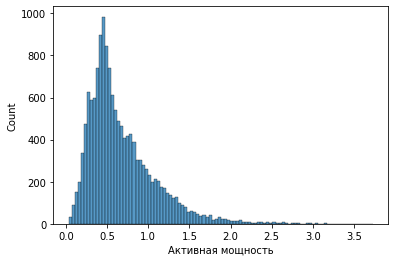

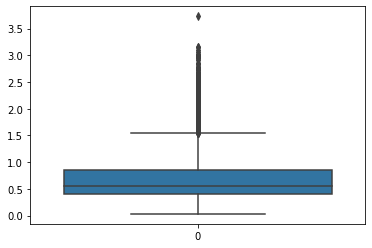

In [6]:
sns.histplot(data=df_arc['Активная мощность'], bins = 100)
plt.show()
sns.boxplot(data=df_arc['Активная мощность'])
plt.show()

На гистограмме видно распределение, сходное с нормальным. При этом есть скошенность вправо, что говорит о большом значении экстремальных значений. Это подтверждается на графике 'ящик с усами'.

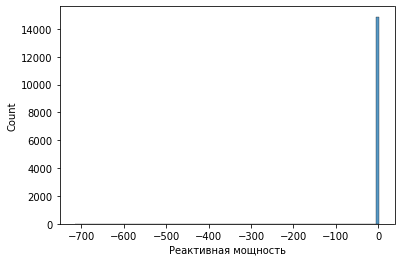

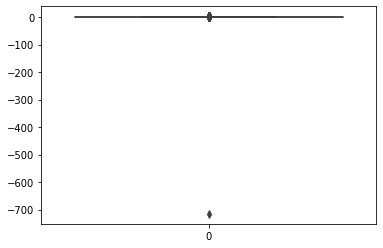

In [7]:
sns.histplot(data=df_arc['Реактивная мощность'], bins = 100)
plt.show()
sns.boxplot(data=df_arc['Реактивная мощность'])
plt.show()

Необходимо избавиться от невозможного отрицательного значения и посмотреть еще раз.

In [8]:
df_arc.drop(df_arc[df_arc['Реактивная мощность'] < 0].index, inplace=True)

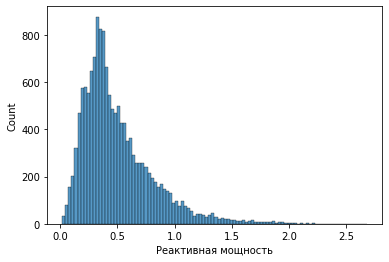

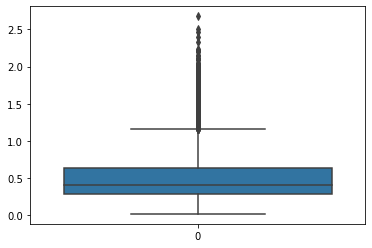

In [9]:
sns.histplot(data=df_arc['Реактивная мощность'], bins = 100)
plt.show()
sns.boxplot(data=df_arc['Реактивная мощность'])
plt.show()

Получили картину, схожую с тем, что было у данных по активной мощности.

In [10]:
try:
    df_bulk = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_bulk.csv")
except:
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

df_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [11]:
df_bulk.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [12]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Видно, что в информации по сыпучим материалам очень много пропусков. Кроме того, материал под номером 8 использовался всего один раз, поэтому можно от него избавиться.

In [13]:
df_bulk.drop(['Bulk 8'], axis = 1, inplace = True)

In [14]:
df_bulk.fillna(0,inplace=True)

In [15]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 9   3129 non-null   float64
 9   Bulk 10  3129 non-null   float64
 10  Bulk 11  3129 non-null   float64
 11  Bulk 12  3129 non-null   float64
 12  Bulk 13  3129 non-null   float64
 13  Bulk 14  3129 non-null   float64
 14  Bulk 15  3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 366.8 KB


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

<Figure size 432x288 with 0 Axes>

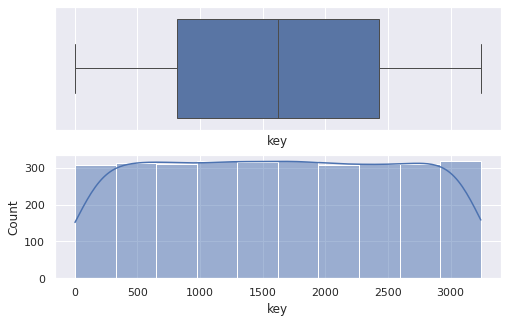

<Figure size 576x360 with 0 Axes>

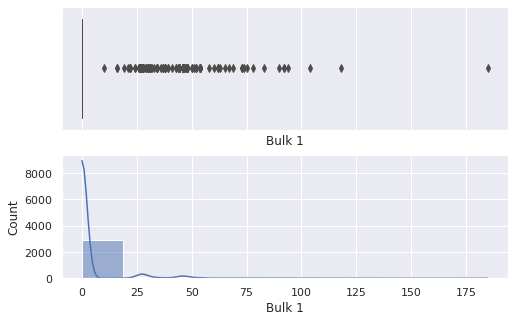

<Figure size 576x360 with 0 Axes>

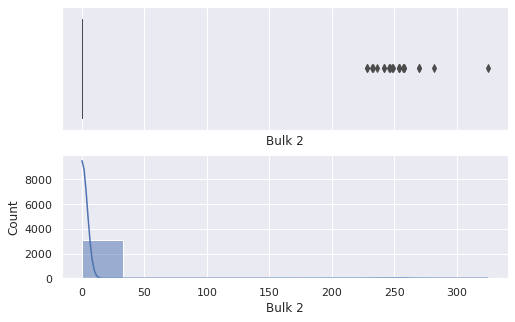

<Figure size 576x360 with 0 Axes>

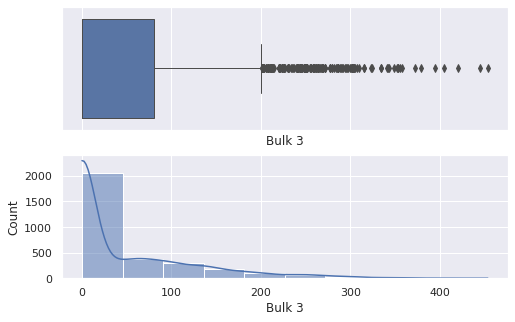

<Figure size 576x360 with 0 Axes>

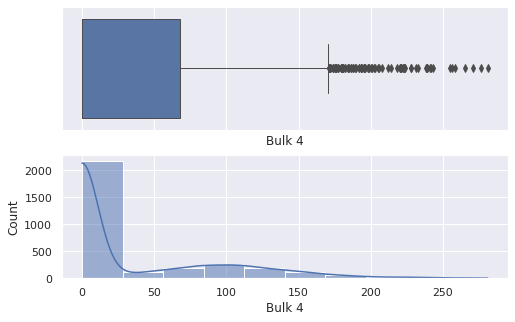

<Figure size 576x360 with 0 Axes>

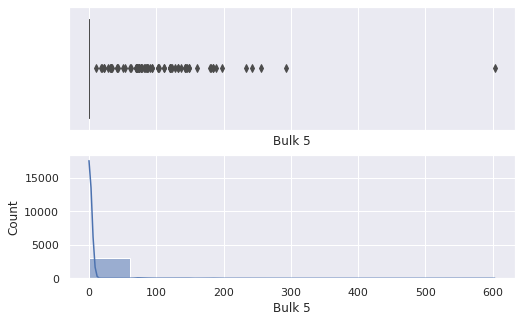

<Figure size 576x360 with 0 Axes>

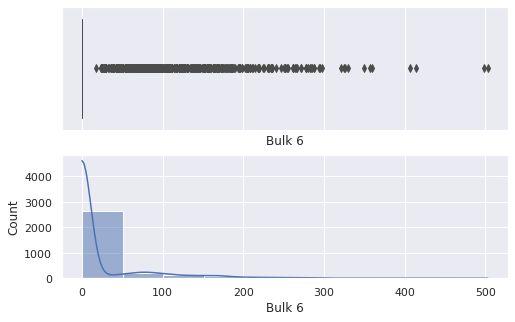

<Figure size 576x360 with 0 Axes>

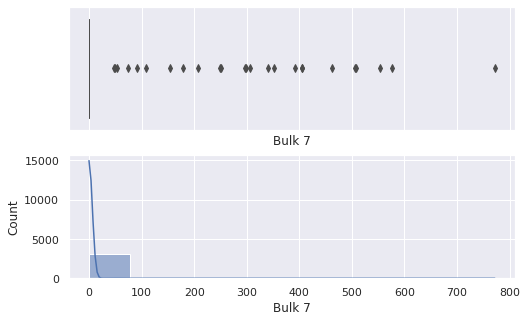

<Figure size 576x360 with 0 Axes>

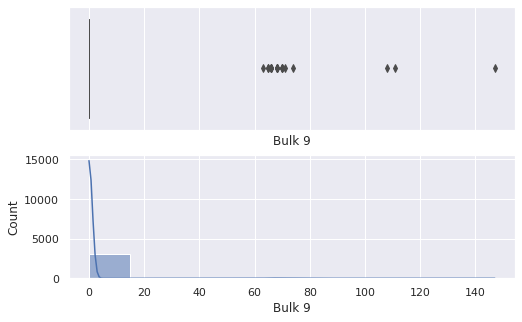

<Figure size 576x360 with 0 Axes>

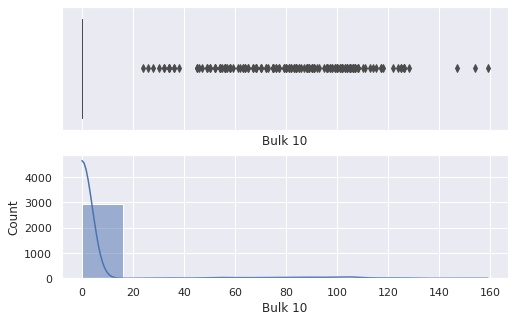

<Figure size 576x360 with 0 Axes>

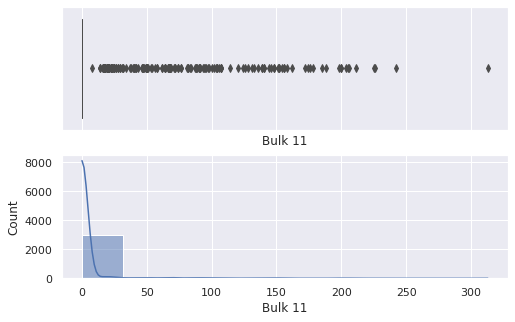

<Figure size 576x360 with 0 Axes>

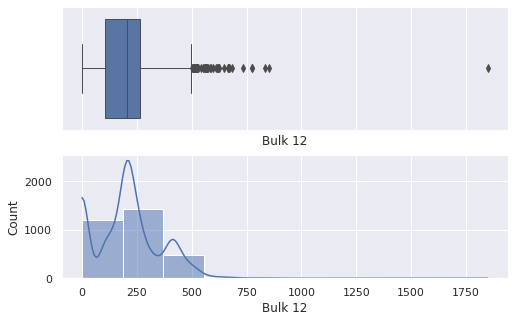

<Figure size 576x360 with 0 Axes>

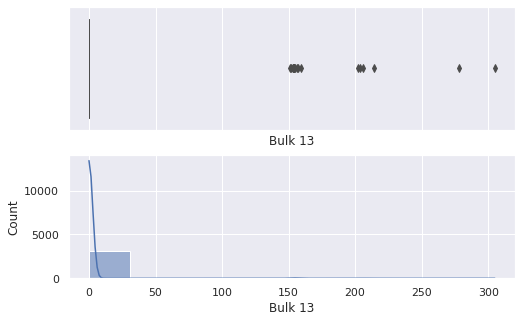

<Figure size 576x360 with 0 Axes>

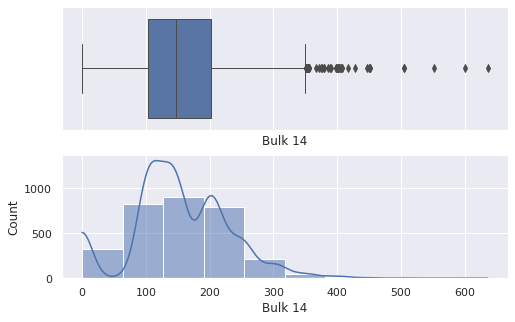

<Figure size 576x360 with 0 Axes>

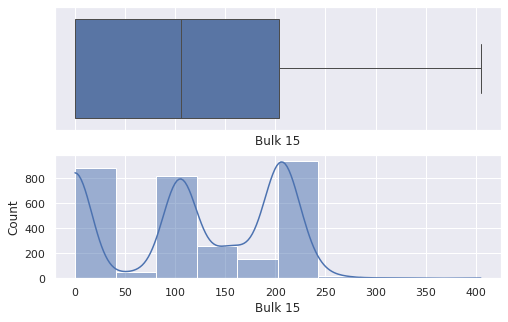

In [16]:
for i in df_bulk.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i)
    sns.boxplot(df_bulk[i], ax=ax_box , linewidth= 1.0)
    sns.histplot(df_bulk[i], ax=ax_hist , bins = 10,kde=True)

Видно, что есть случаи неравномерного распределения сыпучих материалов. У № 12 также есть очевидная группа выбросов, лежащая крайне далеко от остальных. 

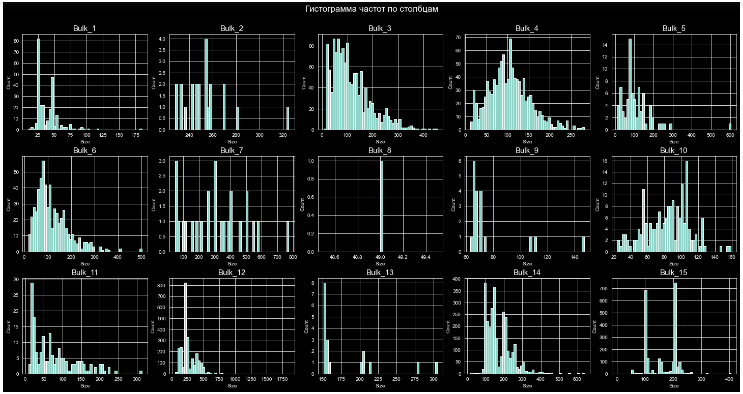

In [17]:
try:
    df_bulk_time = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_bulk_time.csv")
except:
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

df_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [18]:
df_bulk_time.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


In [19]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Замечания здесь аналогичны предыдущему датасету, так как он просто показывает время добавления сыпучих материалов, которые мы рассмотрели ранее.

In [20]:
df_bulk_time.drop(['Bulk 8'], axis = 1, inplace = True)

df_bulk_time.fillna(0,inplace=True)

df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   3129 non-null   object
 2   Bulk 2   3129 non-null   object
 3   Bulk 3   3129 non-null   object
 4   Bulk 4   3129 non-null   object
 5   Bulk 5   3129 non-null   object
 6   Bulk 6   3129 non-null   object
 7   Bulk 7   3129 non-null   object
 8   Bulk 9   3129 non-null   object
 9   Bulk 10  3129 non-null   object
 10  Bulk 11  3129 non-null   object
 11  Bulk 12  3129 non-null   object
 12  Bulk 13  3129 non-null   object
 13  Bulk 14  3129 non-null   object
 14  Bulk 15  3129 non-null   object
dtypes: int64(1), object(14)
memory usage: 366.8+ KB


In [21]:
try:
    df_gas = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_gas.csv")
except:
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

df_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [22]:
df_gas.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [23]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков, нулей и отрицательных значений нет. Посмотрим на данные, используя графики:

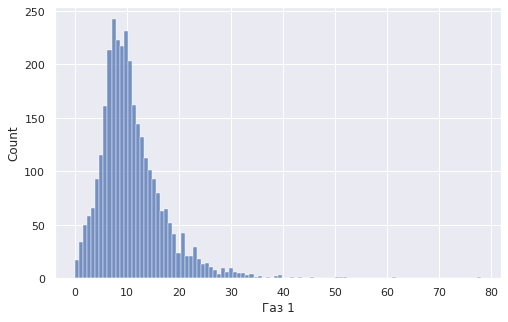

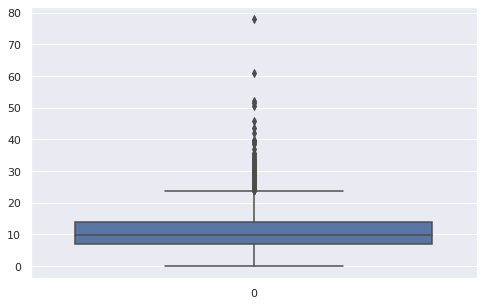

In [24]:
sns.histplot(data=df_gas['Газ 1'], bins = 100)
plt.show()
sns.boxplot(data=df_gas['Газ 1'])
plt.show()

На гистограмме видно распределение, сходное с нормальным. При этом есть скошенность вправо, что говорит о некотором количестве экстремальных значений. Это подтверждается на графике 'ящик с усами'.

In [25]:
try:
    df_temp = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_temp.csv")
except:
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [26]:
df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Температура,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


In [27]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Наблюдается большоек количество пропусков, от которых необходимо избавиться.

In [28]:
df_temp = df_temp.dropna(subset=['Температура'])

In [29]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13006 non-null  int64  
 1   Время замера  13006 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB


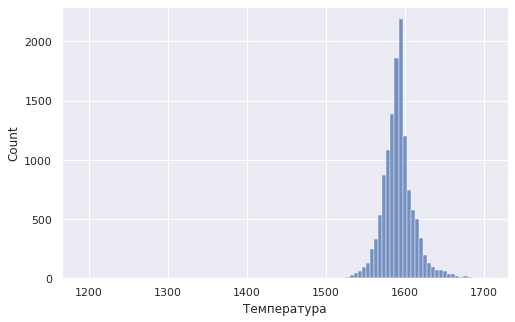

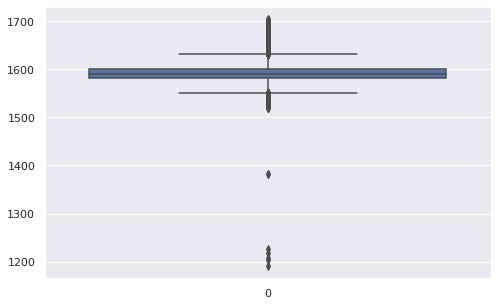

In [30]:
sns.histplot(data=df_temp['Температура'], bins = 100)
plt.show()
sns.boxplot(data=df_temp['Температура'])
plt.show()

Отчетливо наблюдается группа выбросов, чьи значения опускаются даже ниже отметки 1200. Учитывая сущность технологического процесса, считаю необходимым удалить данные показания, так как температура плавления стали не может быть ниже 1400 градусов по Цельсию.  

In [31]:
df_temp[df_temp['Температура'] < 1400]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [32]:
df_temp.drop(df_temp[(df_temp['key'] == 867) | (df_temp['key'] == 1214) | (df_temp['key'] == 1619) | (df_temp['key'] == 1818) | (df_temp['key'] == 2052) | (df_temp['key'] == 2561)].index, inplace=True)

In [33]:
df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
key,12961.0,1327.863128,805.708590,1.0,636.0,1315.0,1978.0,3241.0
Температура,12961.0,1591.956176,19.786049,1519.0,1581.0,1591.0,1601.0,1705.0


In [34]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [35]:
try:
    df_wire = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_wire.csv")
except:
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

df_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [37]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Как и в случае с сыпучими материалами, можно сказать, что наблюдается большое количество пропусков. Проволочный материал №5 встречается всего один раз и может быть удален.

In [38]:
df_wire.drop(['Wire 5'], axis = 1, inplace = True)

In [39]:
df_wire.fillna(0,inplace=True)


In [40]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 6  3081 non-null   float64
 6   Wire 7  3081 non-null   float64
 7   Wire 8  3081 non-null   float64
 8   Wire 9  3081 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

<Figure size 576x360 with 0 Axes>

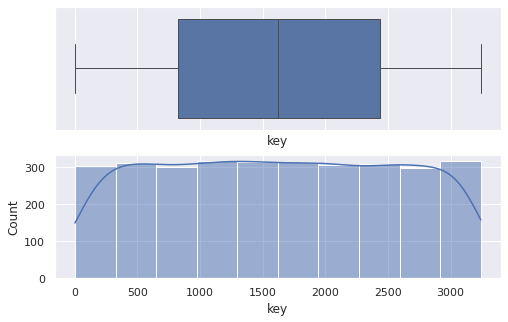

<Figure size 576x360 with 0 Axes>

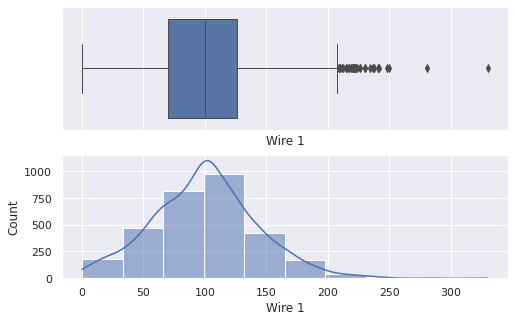

<Figure size 576x360 with 0 Axes>

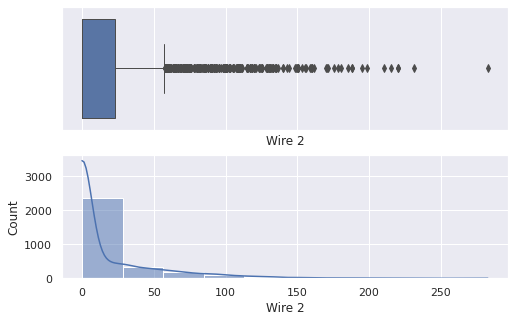

<Figure size 576x360 with 0 Axes>

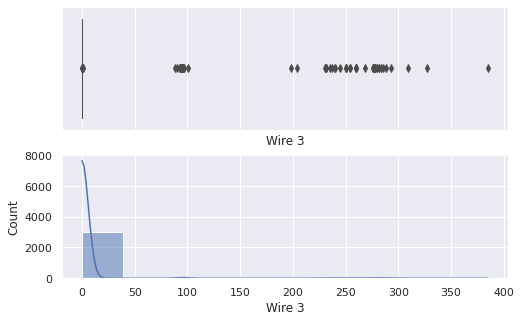

<Figure size 576x360 with 0 Axes>

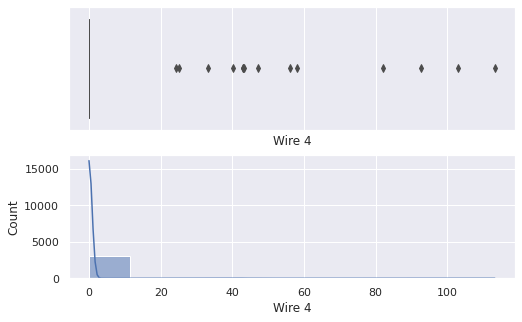

<Figure size 576x360 with 0 Axes>

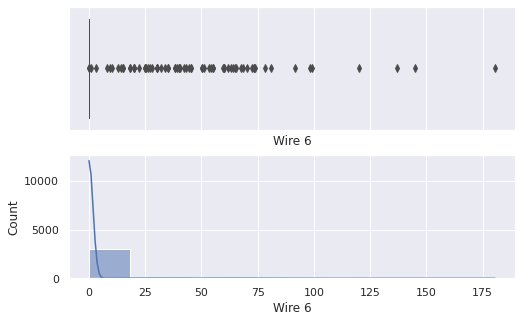

<Figure size 576x360 with 0 Axes>

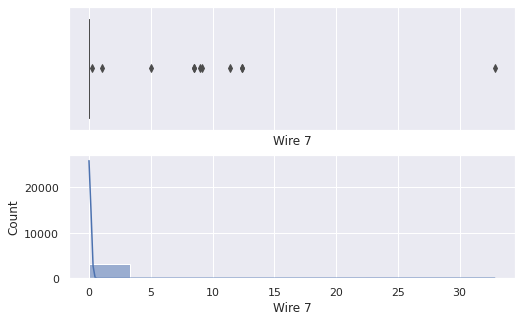

<Figure size 576x360 with 0 Axes>

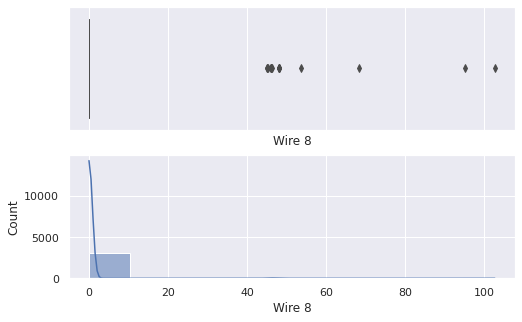

<Figure size 576x360 with 0 Axes>

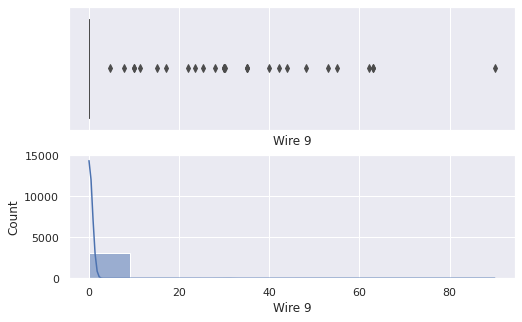

In [41]:
for i in df_wire.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(8, 5)})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i)
    sns.boxplot(df_wire[i], ax=ax_box , linewidth= 1.0)
    sns.histplot(df_wire[i], ax=ax_hist , bins = 10,kde=True)

Можно заметить, что первый проволочный материал использовался практически постоянно, второй - в трети случаев,а все остальные - довольно ограниченное количество раз. Есть отдельные случаи выбросов (например, в случае №7).

In [42]:
try:
    df_wire_time = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/Final/data_wire_time.csv")
except:
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

df_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_wire_time.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


In [44]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Замечания здесь аналогичны предыдущему датасету, так как он просто показывает время добавления проволочных материалов, которые мы рассмотрели ранее.

In [45]:
df_wire_time.drop(['Wire 5'], axis = 1, inplace = True)

df_wire_time.fillna(0,inplace=True)

df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3081 non-null   object
 2   Wire 2  3081 non-null   object
 3   Wire 3  3081 non-null   object
 4   Wire 4  3081 non-null   object
 5   Wire 6  3081 non-null   object
 6   Wire 7  3081 non-null   object
 7   Wire 8  3081 non-null   object
 8   Wire 9  3081 non-null   object
dtypes: int64(1), object(8)
memory usage: 216.8+ KB


### 1.2 Преобразование данных

После проведения первичного анализа, нужно преобразовать некоторые данные для последующего их использования в обучении модели.

Сначала узнаем время, которое было затрачено на нагрев в датасете об электродах. Затем умножим его на сумму активной и реактивной мощностей, чтобы получить работу.

In [46]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

df_arc['Время нагрева'] = df_arc['Конец нагрева дугой']-df_arc['Начало нагрева дугой']

df_arc['Работа'] = (df_arc['Время нагрева'])/timedelta(minutes=1)*df_arc['Активная мощность']
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48,3.709023
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05,2.483955
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52,2.133842
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05,10.094456
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28,1.708795
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0 days 00:02:17,1.000245
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,0 days 00:05:38,7.303138
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0 days 00:02:06,1.029791
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0 days 00:03:30,2.897101
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,0 days 00:04:40,4.956247


Оставим только те партии, где измерение температуры проводилось более 1 раза:

In [47]:
df_temp = df_temp[df_temp['key'].duplicated(keep=False)]

In [48]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [49]:
target_temp = df_temp.sort_values('Время замера').groupby('key').tail(1)
target_temp.head(10)

,key,Время замера,Температура
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0
15,3,2019-05-03 12:34:57,1599.0
18,4,2019-05-03 12:59:25,1625.0
20,5,2019-05-03 13:36:01,1602.0
25,6,2019-05-03 14:12:29,1596.0
30,7,2019-05-03 14:42:37,1599.0
34,8,2019-05-03 15:22:52,1598.0
39,9,2019-05-03 16:01:16,1592.0
47,10,2019-05-03 16:36:08,1593.0


Получим среднее значение работы для каждой партии:

In [50]:
start_temp = df_temp.sort_values('Время замера').groupby('key').head(1)
start_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
5,2,2019-05-03 11:37:27,1581.0
11,3,2019-05-03 12:13:17,1596.0
16,4,2019-05-03 12:52:57,1601.0
19,5,2019-05-03 13:23:19,1576.0
21,6,2019-05-03 13:49:24,1543.0
26,7,2019-05-03 14:19:43,1586.0
31,8,2019-05-03 15:07:18,1577.0
35,9,2019-05-03 15:37:03,1587.0
40,10,2019-05-03 16:14:29,1574.0


In [51]:
arc_by_key = df_arc.pivot_table(index=['key'],values=['Работа'],aggfunc={'Работа':'mean'}).reset_index()
arc_by_key.head(10)

,key,Работа
0,1,4.026014
1,2,3.057569
2,3,1.478611
3,4,2.794431
4,5,4.156234
5,6,4.821933
6,7,2.593644
7,8,5.195689
8,9,1.104851
9,10,1.272595


In [52]:
arc_by_key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3214 non-null   int64  
 1   Работа  3214 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


Помимо этого, необходимо получить целевую переменную из датасета df_temp. Ей будет являться температура, полученная в ходе последнего замера. 

Кроме того, мы можем извлечь значения температуры при первом замере и использовать их в качестве одного из признаков:

После всех необходимых преобразований составим план дальнейшей работы по созданию модели.

## План решения задачи

Были выполнены следующие шаги:

- Получение данных, постановка цели, определение задач для достижения цели, изучение особенностей технологического процесса обработки стали, определение метрики и её необходимых значений
- Исследовательский анализ данных (EDA), включающий в себя изучение общей информации о данных, поиск дубликатов, пропусков, аномалий, некорректных наименований столбцов, некорректных типов данных, внесение корректировок на основании наблюдений. Отдельно стоит отметить анализ вышеперечисленных деталей с помощью построения графиков - гистограммы и ящика с усами.




Составим список пунктов, необходимых для расчета требуемой метрики:

- Подготовка данных к машинному обучению, включая выделение целевой переменной и признаков, объединение их в общий датасет, а также проверка взаимосвязей между признаками (в т. ч. наличие или отсутствие мультиколлинеарности), принятие решений по выбору модели на основе наблюдений
- Построение модели: деление на выборки, масштабирование признаков (при необходимости), выполнение обучения разных моделей с различными гиперпараметрами (линейная регрессия, случайный лес и алгоритм Catboost)
- Выбор лучшей модели по итогам их обучения на обучающей выборке и её запуск на тестовой выборке
- Рассмотрение важности признаков по итогам работы модели и интерпретация результатов машинного обучения

#### План работы:  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - ...
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков (если надо)
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке

## 2. Построение модели

### 2.1 Формирование таблицы признаков

Сначала необходимо объединить таблицы с целевой переменной и всеми необходимыми для моделирования признаками.

In [53]:
final_table = target_temp.merge(start_temp,on='key',how='inner').merge(arc_by_key,on='key',how='inner').merge(df_bulk,on='key',how='inner').merge(df_gas,on='key',how='inner').merge(df_wire,on='key',how='inner')

In [54]:
final_table

,key,Время замера_x,Температура_x,Время замера_y,Температура_y,Работа,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.026014,0.0,0.0,0.0,43.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.057569,0.0,0.0,0.0,73.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,1.478611,0.0,0.0,0.0,34.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,2.794431,0.0,0.0,0.0,81.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,4.156234,0.0,0.0,0.0,78.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,2.609031,0.0,0.0,21.0,0.0,...,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,2.021856,0.0,0.0,0.0,63.0,...,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,2.375197,0.0,0.0,0.0,85.0,...,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,2.099762,0.0,0.0,90.0,0.0,...,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Проверим модель на мультиколлинеарность:

In [55]:
corr = final_table.corr()
corr.style.background_gradient(cmap='coolwarm')

,key,Температура_x,Температура_y,Работа,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.097052,-0.016458,0.003913,-0.078148,-0.006170,-0.006326,-0.026572,0.035279,0.006424,0.052393,-0.039700,0.063011,0.035023,0.026272,-0.015770,-0.109798,-0.045209,-0.043059,-0.013728,0.043359,-0.027229,0.049296,-0.008189,0.037029,-0.035977,0.021361
Температура_x,-0.097052,1.000000,0.301961,0.220127,-0.075233,-0.082466,-0.036767,0.188100,-0.028365,-0.181880,-0.107289,-0.016081,0.061345,-0.114777,0.267379,-0.010925,0.114520,0.266386,0.059036,0.317702,-0.206837,-0.047548,-0.159737,-0.084049,-0.137275,-0.010772,-0.027496
Температура_y,-0.016458,0.301961,1.000000,-0.456119,0.079137,0.141555,-0.113271,0.165562,0.078745,-0.127241,0.087781,-0.033382,0.035824,-0.110397,-0.079339,0.020248,-0.180058,-0.062137,0.036730,0.262946,-0.101012,-0.003386,0.076134,0.020749,0.052816,-0.029819,0.002653
Работа,0.003913,0.220127,-0.456119,1.000000,0.033030,-0.027443,0.040841,-0.035572,-0.041400,0.050842,-0.035208,-0.018798,-0.013535,0.041378,0.415410,0.036497,0.368413,0.304216,0.140136,-0.072073,-0.019994,-0.008001,-0.029552,0.026553,-0.024401,-0.018056,-0.001522
Bulk 1,-0.078148,-0.075233,0.079137,0.033030,1.000000,0.224682,-0.011462,0.041733,0.060378,-0.003822,0.237198,-0.019791,-0.023304,-0.037985,0.325753,-0.010316,0.207525,-0.001041,0.234081,0.013896,-0.009198,0.020217,0.146281,0.148519,0.083434,-0.019570,0.011023
Bulk 2,-0.006170,-0.082466,0.141555,-0.027443,0.224682,1.000000,-0.046929,0.040773,0.360293,-0.030039,0.679353,-0.005342,-0.018047,0.001455,-0.099044,-0.005602,-0.141193,-0.105807,0.217442,-0.169589,-0.039061,0.223191,0.699340,0.558883,0.431735,-0.005282,-0.006854
Bulk 3,-0.006326,-0.036767,-0.113271,0.040841,-0.011462,-0.046929,1.000000,-0.295303,-0.006734,0.065696,-0.033501,0.011408,-0.085192,-0.007331,0.018409,-0.013364,0.011061,-0.012791,0.059651,0.037950,0.095025,0.005870,-0.040561,0.007204,-0.019465,0.004904,0.004693
Bulk 4,-0.026572,0.188100,0.165562,-0.035572,0.041733,0.040773,-0.295303,1.000000,0.028303,-0.251889,0.045880,-0.002975,-0.084900,-0.119670,0.105505,0.003174,-0.091238,0.101169,0.017521,0.298265,-0.267932,-0.039291,0.034404,-0.011475,0.033827,0.007800,-0.058206
Bulk 5,0.035279,-0.028365,0.078745,-0.041400,0.060378,0.360293,-0.006734,0.028303,1.000000,-0.021937,0.288329,-0.008446,-0.028531,-0.015879,-0.072855,-0.008856,-0.066124,-0.067325,0.086867,-0.013421,-0.013784,0.070894,0.262754,0.204801,0.172137,-0.008351,-0.010836
Bulk 6,0.006424,-0.181880,-0.127241,0.050842,-0.003822,-0.030039,0.065696,-0.251889,-0.021937,1.000000,-0.025148,-0.028815,-0.097343,0.196636,-0.113197,0.042586,0.177098,-0.109732,0.139475,-0.235764,0.204771,-0.046605,-0.025964,-0.020304,-0.012460,-0.028493,-0.013401


In [56]:
corr = final_table.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm')

,key,Температура_x,Температура_y,Работа,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.102552,-0.029774,0.001750,-0.062489,-0.006317,0.029552,-0.020081,0.021189,0.027338,0.043458,-0.061915,0.040288,0.091968,0.045011,-0.014456,-0.138994,0.024529,-0.026672,-0.015690,0.050124,-0.019837,0.033777,-0.044949,0.049900,-0.061913,0.022885
Температура_x,-0.102552,1.000000,0.308799,0.182561,-0.046473,-0.012595,-0.036616,0.235319,-0.031853,-0.264200,-0.062720,-0.008415,0.048541,-0.119719,0.240560,-0.016034,0.063956,0.226590,0.042534,0.298392,-0.235069,-0.040840,-0.031615,-0.018835,-0.071797,-0.008319,-0.031839
Температура_y,-0.029774,0.308799,1.000000,-0.498110,0.065435,0.116195,-0.112695,0.192983,0.047710,-0.171428,0.045487,-0.038053,0.034822,-0.098738,-0.074019,0.025520,-0.160694,-0.062817,0.032021,0.270993,-0.111513,0.034341,0.073191,0.029192,0.060927,-0.038125,-0.001181
Работа,0.001750,0.182561,-0.498110,1.000000,0.032313,-0.035423,0.058291,-0.071856,-0.051184,0.057555,-0.043370,-0.008988,-0.015296,0.035516,0.425503,0.002543,0.379077,0.345766,0.128969,-0.093979,-0.028600,-0.016835,-0.023708,0.000458,-0.028842,-0.008880,-0.002476
Bulk 1,-0.062489,-0.046473,0.065435,0.032313,1.000000,0.210866,-0.008633,0.055526,0.081042,-0.003304,0.167689,-0.022913,-0.027538,-0.046929,0.251599,-0.004886,0.181367,0.026240,0.154546,0.056171,-0.046456,0.081744,0.152801,0.152092,0.138322,-0.022913,0.000185
Bulk 2,-0.006317,-0.012595,0.116195,-0.035423,0.210866,1.000000,-0.059954,0.060953,0.492462,-0.035866,0.614414,-0.005623,-0.019183,0.006852,-0.101658,-0.005836,-0.115441,-0.095761,0.113988,-0.127614,-0.053157,0.524475,0.799770,0.538252,0.554519,-0.005623,-0.007658
Bulk 3,0.029552,-0.036616,-0.112695,0.058291,-0.008633,-0.059954,1.000000,-0.383761,-0.038042,-0.052603,-0.048472,0.034194,-0.067368,-0.053469,0.017980,-0.022351,0.014086,-0.013764,0.058747,0.032481,0.116428,-0.004822,-0.057590,0.001903,-0.033192,0.034143,0.019118
Bulk 4,-0.020081,0.235319,0.192983,-0.071856,0.055526,0.060953,-0.383761,1.000000,0.019460,-0.332291,0.042549,-0.016122,-0.043244,-0.170168,0.097405,0.003009,-0.120436,0.081750,-0.009009,0.342622,-0.311508,-0.002051,0.040791,-0.023009,0.051809,-0.016128,-0.066674
Bulk 5,0.021189,-0.031853,0.047710,-0.051184,0.081042,0.492462,-0.038042,0.019460,1.000000,0.029571,0.300193,-0.011452,-0.039070,-0.024509,-0.104656,-0.011887,-0.061226,-0.076744,0.069824,-0.032520,0.034542,0.247660,0.392461,0.253546,0.273158,-0.011452,-0.015597
Bulk 6,0.027338,-0.264200,-0.171428,0.057555,-0.003304,-0.035866,-0.052603,-0.332291,0.029571,1.000000,-0.022995,-0.035866,-0.122365,0.351454,-0.132396,0.043971,0.175581,-0.104655,0.110578,-0.349008,0.204085,-0.053037,-0.034452,-0.022458,-0.019856,-0.035866,-0.026322


Видно, что некоторые признаки очень сильно коррелируют между собой. Учтем это при отборе финального списка признаков.

In [57]:
final_table.columns

Index(['key', 'Время замера_x', 'Температура_x', 'Время замера_y',
       'Температура_y', 'Работа', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3',
       'Wire 4', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [58]:
final_table = final_table.rename(columns={"Температура_x": "Конечная температура", "Температура_y": "Начальная температура"})

In [59]:
final_table

,key,Время замера_x,Конечная температура,Время замера_y,Начальная температура,Работа,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,4.026014,0.0,0.0,0.0,43.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,3.057569,0.0,0.0,0.0,73.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,1.478611,0.0,0.0,0.0,34.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,2.794431,0.0,0.0,0.0,81.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,4.156234,0.0,0.0,0.0,78.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,2.609031,0.0,0.0,21.0,0.0,...,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2321,2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,2.021856,0.0,0.0,0.0,63.0,...,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2322,2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,2.375197,0.0,0.0,0.0,85.0,...,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2323,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0,2.099762,0.0,0.0,90.0,0.0,...,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
taglist = ['Начальная температура', 'Работа', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4',
       'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3',
       'Wire 4', 'Wire 6', 'Wire 7', 'Wire 9']

X = final_table[taglist]
y = final_table['Конечная температура']

In [61]:
X

,Начальная температура,Работа,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,...,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9
0,1571.0,4.026014,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
1,1581.0,3.057569,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
2,1596.0,1.478611,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
3,1601.0,2.794431,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,...,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
4,1576.0,4.156234,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,1570.0,2.609031,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,...,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0
2321,1554.0,2.021856,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,...,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0
2322,1571.0,2.375197,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,...,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0
2323,1591.0,2.099762,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,...,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0


In [62]:
y

0       1613.0
1       1602.0
2       1599.0
3       1625.0
4       1602.0
         ...  
2320    1591.0
2321    1591.0
2322    1589.0
2323    1594.0
2324    1603.0
Name: Конечная температура, Length: 2325, dtype: float64

Разделим датасет на обучающую и тестовую выборки:

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3102022)

Начнем обучение с линейной регрессии:

In [65]:
scaler = StandardScaler().fit(X_train)
X_std = scaler.transform(X_train)
lm = LinearRegression()
scores = np.mean(cross_val_score(lm, X_std, y_train, scoring='neg_mean_absolute_error', cv=5))
scores 

-7.700702846549284

Далее рассмотрим случайный лес и подберем наилучшие параметры:

In [66]:
params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [5, 10],
 'n_estimators': [100, 200, 300]}


In [67]:
rf = RandomForestRegressor()
grid_forest = GridSearchCV(estimator = rf, param_grid = params, scoring='neg_mean_absolute_error', cv = 5, verbose=2, n_jobs = -1)
grid_forest.fit(X_train, y_train)
grid_forest.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; tot

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

In [68]:
grid_forest.best_score_

-6.68277381976534

Наконец, найдем наилучший список параметров для алгоритма градиентного бустинга Catboost:

In [67]:
 parameters = {'depth':[3,6,9],
          'iterations':[50, 100, 300],
          'learning_rate':[0.01,0.1, 0.3], 
          'l2_leaf_reg':[1,3],
          'loss_function':['MAE','RMSE']}


In [68]:
cbc = CatBoostRegressor()
grid_cat = GridSearchCV(estimator=cbc, param_grid = parameters, scoring='neg_mean_absolute_error', cv = 5, n_jobs=-1, verbose = 2)
grid_cat.fit(X_train, y_train)
grid_cat.best_params_

In [69]:
grid_cat.best_score_

In [70]:
results_table = pd.DataFrame({
        "Метрика NMAE": [-7.70, -6.68, -6.61]
        
    }, index=['Линейная регрессия','Случайный лес','Catboost']
              )

print(results_table)

Похоже, Catboost показал наилучший результат. Рассчитаем среднюю абсолютную ошибку, используя наилучший набор гиперпараметров:

In [69]:
best_model = CatBoostRegressor(loss_function = 'MAE', depth = 3, iterations = 300, l2_leaf_reg = 3, learning_rate = 0.1, verbose = 2)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print('Средняя абсолютная ошибка на тестовой выборке равняется:', mae)


0:	learn: 7.9950650	total: 47.5ms	remaining: 14.2s
2:	learn: 7.8505406	total: 49.3ms	remaining: 4.88s
4:	learn: 7.7018556	total: 51ms	remaining: 3.01s
6:	learn: 7.5346649	total: 52.8ms	remaining: 2.21s
8:	learn: 7.4595469	total: 55ms	remaining: 1.78s
10:	learn: 7.3598358	total: 56.9ms	remaining: 1.5s
12:	learn: 7.2541845	total: 58.6ms	remaining: 1.29s
14:	learn: 7.1640300	total: 60.2ms	remaining: 1.14s
16:	learn: 7.1151481	total: 62ms	remaining: 1.03s
18:	learn: 7.0769581	total: 63.8ms	remaining: 944ms
20:	learn: 7.0010749	total: 65.7ms	remaining: 872ms
22:	learn: 6.9445325	total: 67.4ms	remaining: 812ms
24:	learn: 6.8827522	total: 68.9ms	remaining: 758ms
26:	learn: 6.8250136	total: 70.6ms	remaining: 713ms
28:	learn: 6.7830907	total: 72.1ms	remaining: 674ms
30:	learn: 6.7503838	total: 73.8ms	remaining: 640ms
32:	learn: 6.7216642	total: 75.4ms	remaining: 610ms
34:	learn: 6.6916047	total: 76.9ms	remaining: 583ms
36:	learn: 6.6538900	total: 78.7ms	remaining: 559ms
38:	learn: 6.6062334	tot

Используя метод SHAP, посмотрим, какие признаки оказались определяющими по своему влиянию на целевую переменную:

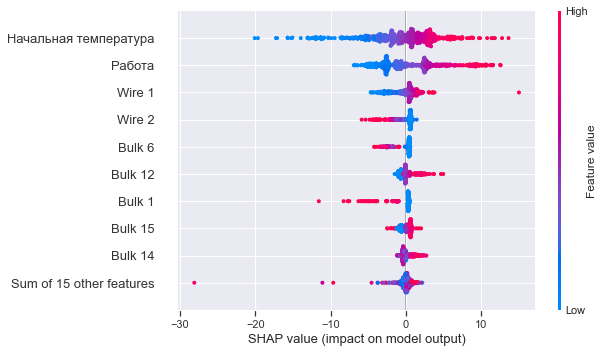

In [82]:
explainer = shap.Explainer(best_model.predict, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

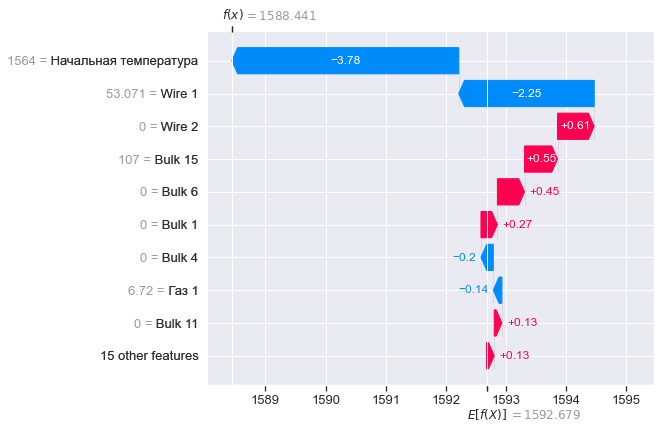

In [83]:
shap.plots.waterfall(shap_values[0])

Как и ожидалось, начальная температура оказалась важнейшим признаком. Помимо неё, важное значение имеют проволочные материалы №1 и №2, сыпучий материал №15.

In [70]:
taglist = ['Начальная температура', 'Bulk 15', 'Wire 1', 'Wire 2']

X_1 = final_table[taglist]
y_1 = final_table['Конечная температура']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.25, random_state=3102022)

In [72]:
best_model = CatBoostRegressor(loss_function = 'MAE', depth = 3, iterations = 300, l2_leaf_reg = 3, learning_rate = 0.1, verbose = 2)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print('Средняя абсолютная ошибка на тестовой выборке равняется:', mae)


0:	learn: 8.0078590	total: 606us	remaining: 181ms
2:	learn: 7.8362451	total: 1.65ms	remaining: 163ms
4:	learn: 7.7003546	total: 2.44ms	remaining: 144ms
6:	learn: 7.6059247	total: 3.28ms	remaining: 137ms
8:	learn: 7.5169542	total: 4.03ms	remaining: 130ms
10:	learn: 7.4483529	total: 4.97ms	remaining: 131ms
12:	learn: 7.3930237	total: 6ms	remaining: 132ms
14:	learn: 7.3349418	total: 6.84ms	remaining: 130ms
16:	learn: 7.2928732	total: 7.56ms	remaining: 126ms
18:	learn: 7.2648769	total: 8.27ms	remaining: 122ms
20:	learn: 7.2369541	total: 8.97ms	remaining: 119ms
22:	learn: 7.2094587	total: 9.72ms	remaining: 117ms
24:	learn: 7.1902280	total: 10.4ms	remaining: 115ms
26:	learn: 7.1667687	total: 11.2ms	remaining: 113ms
28:	learn: 7.1397929	total: 12ms	remaining: 112ms
30:	learn: 7.1222160	total: 12.8ms	remaining: 111ms
32:	learn: 7.1119442	total: 13.5ms	remaining: 109ms
34:	learn: 7.1007370	total: 14.3ms	remaining: 108ms
36:	learn: 7.0908712	total: 15ms	remaining: 106ms
38:	learn: 7.0760635	tota

Опробовав те же параметры наилучшей модели всего на 4 признаках, получили результат, ненамного уступающий значению, полученному на полном наборе признаков.

"В отчёте ответьте на вопросы:<br>
- Какие пункты плана были выполнены, а какие — нет (поясните почему)?<br>
- Какие трудности возникли и как вы их преодолели?<br>
- Какие ключевые шаги в решении задачи выделили?<br>
- Какая ваша итоговая модель и какое у неё качество?<br>

## 3. Отчет

Основной целью проекта являлась оптимизация производственных расходов металлургического комбината ООО «Так закаляем сталь» в результате уменьшения потребления электроэнергии на этапе обработки стали. Для решения этой задачи необходимо было построить модель и найти оптимальное значение заданной метрики MAE.

В ходе работы были выполнены все пункты плана, описанные в конце первой части работы. Нам удалось подготовить данные к моделированию после предварительного анализа и их отбора после проверки на мультиколлинеарность, а затем обучить на полученных данных 3 различные модели. После этого была выбрана наилучшая модель (алгоритм градиентного бустинга Catboost) на основе выбранного скоринга. Используя оптимальный список гиперпараметров, данная модель была обучена на тестовой выборке и получено итоговое значение метрики MAE. После этого, был проведен анализ признаков методом SHAP, а также проверка модели на 4 наиболее значимых признаках. 

Наиболее сложным в работе оказалось составление итоговой таблицы с признаками перед их моделированием. Для этого необходимо было досконально изучить входные данные и исключить все факторы, способные ухудшить итоговое значение метрики MAE. Чтобы добиться нужного результата, были удалены выбросы в данных, а также произведены многочисленные преобразования, в том числе для получения целевой переменной (крайне важным было то обстоятельство, что замеры температуры для каждой партии должны были производиться минимум дважды). В целом, проект оказался не таким сложным, но требующим пристального внимания к деталям. 

В процессе решения задачи можно выделить следующие ключевые шаги:
- Изучение и анализ данных
- Подготовка данных к машинному обучению
- Обучение моделей
- Выбор наилучшей модели и получение итоговой метрики


Наилучшей моделью оказался алгоритм градиентного бустинга Сatboost, с небольшим перевесом опередивший алгоритм случайного леса. После выбора оптимального набора параметров (depth = 3, iterations = 300, l2_leaf_reg = 3, learning_rate = 0.1) было получено и наилучшее значение искомой метрики MAE - 6.26.

Как показал последующий анализ методом SHAP, важнейшими признаками оказались начальная температура, проволочные материалы №1 и №2, сыпучий материал №15. 

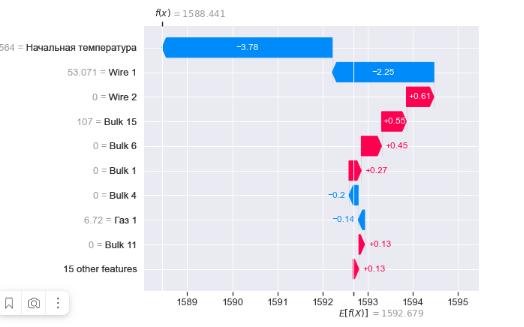